## Preprocessing
Preprocess Raw Data

In [1]:
import pandas as pd
import pickle

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Visualization settings
plt_color = 'olive'
sns.set(font_scale = 2)
sns.set_style(style='white') 

### Read Data

In [3]:
home_df = pd.read_csv('../data/raw/home-listings.csv')
condo_df = pd.read_csv('../data/raw/condo-listings.csv')

In [4]:
raw_listings = pd.concat([home_df, condo_df], axis=0, ignore_index=True)
listings_df = raw_listings.copy()

In [5]:
display(listings_df.head())
print("Number of listings: " + str(len(listings_df)))

,Unnamed: 0,subtype,style,living_area,lot_dimensions,bedrooms,bathrooms,levels,location,listing_date,year_of_construction,municipal_eval,price
0,0,2 Storey,2 storey,1191.3,4076.29,3.0,1.0,2.0,Beauport,202012.0,2004.0,256000.0,332500.0
1,1,Bungalow,Open area,1261.0,9500.00,2.0,1.0,1.0,Deschambault,202112.0,1957.0,150500.0,265000.0
2,2,Townhouse,NaN,1645.0,1360.00,3.0,1.0,3.0,Mercier,202111.0,2006.0,479400.0,612000.0
3,3,Bi-generation,Link,2024.0,17000.00,4.0,3.0,1.0,Stoneham,202112.0,2019.0,NaN,526500.0
4,4,2 Storey,Waterfront,1469.0,16970.00,4.0,2.0,2.0,Trois-Rivières,202111.0,1925.0,NaN,NaN


Number of listings: 128215


### Subtype

In [6]:
listings_df['subtype'].value_counts(dropna=False)

Bungalow                        39393
Condominium                     28902
2 Storey                        27110
Semi-detached                   15022
Townhouse                        6351
Split Level                      4158
1 1/2 Storey                     4046
Country Home                      659
Mobile home                       611
Acreage / Hobby Farm / Ranch      531
Bi-generation                     428
3 Storey                          363
Manufactured home                 184
Loft                              170
Bi-Level                          161
Villa                              63
Penthouse                          41
Misc.                              14
4 Storey                            8
Name: subtype, dtype: int64

Keeping the following: 
\
Bungalow, 2 Storey, Condominium, Semi-detached, Townhouse, Bi-generation, Split Level, 1 1/2 Storey

In [7]:
subtypes = listings_df['subtype'].value_counts()
listings_df = listings_df[listings_df['subtype'].isin(subtypes.keys()[0:9])]

print("Number of listings: " + str(len(listings_df)))

Number of listings: 126252


### Style

In [8]:
listings_df['style'].value_counts(dropna=False).iloc[0:12]

NaN                     23959
Open area               21918
2 storey                19478
Divided Co-Ownership    12145
Detached                11544
New construction         3725
Side split               3332
Semi-detached            3294
Rural                    3031
Townhouse                2726
Executive                2472
Waterfront               2147
Name: style, dtype: int64

Replace NaN styles with Unknown. Keep all other values.

In [9]:
listings_df['style'] = listings_df['style'].fillna('Unknown')

styles = listings_df['style'].value_counts()
listings_df = listings_df[listings_df['style'].isin(styles.keys())]

print("Number of listings: " + str(len(listings_df)))

Number of listings: 126252


### Living Area

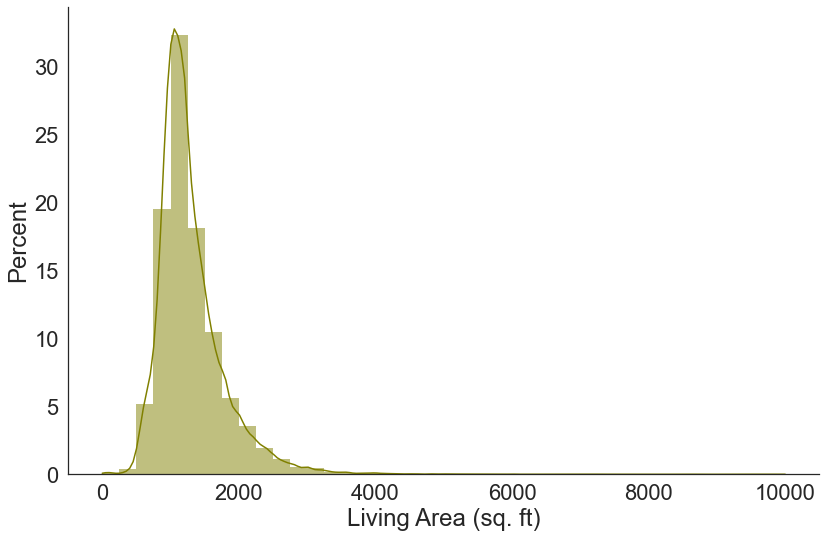

In [10]:
ax = sns.displot(listings_df[listings_df['living_area'] <= 10000], x='living_area', kde=True, stat='percent', fill=True, bins=40, height=8, aspect=1.5, linewidth=0, color=plt_color)
ax.set(xlabel="Living Area (sq. ft)")
plt.savefig('./figures/preprocessing/living-area-hist-orig.png', transparent=True)

In [11]:
min_living_area = 500
max_living_area = 5000

In [12]:
listings_df = listings_df[listings_df['living_area'] >= min_living_area]
listings_df = listings_df[listings_df['living_area'] <= max_living_area]
listings_df['living_area'] = listings_df['living_area'].astype(int)

Replace NaN values with mean value.

In [13]:
mean_living_area = listings_df['living_area'].dropna().mean()
print("Mean Living Area: " + str(mean_living_area))

# Fill the NaN living areas with the mean value
listings_df['living_area'] = listings_df['living_area'].fillna(mean_living_area)

Mean Living Area: 1295.9358747770304


Final Distribution

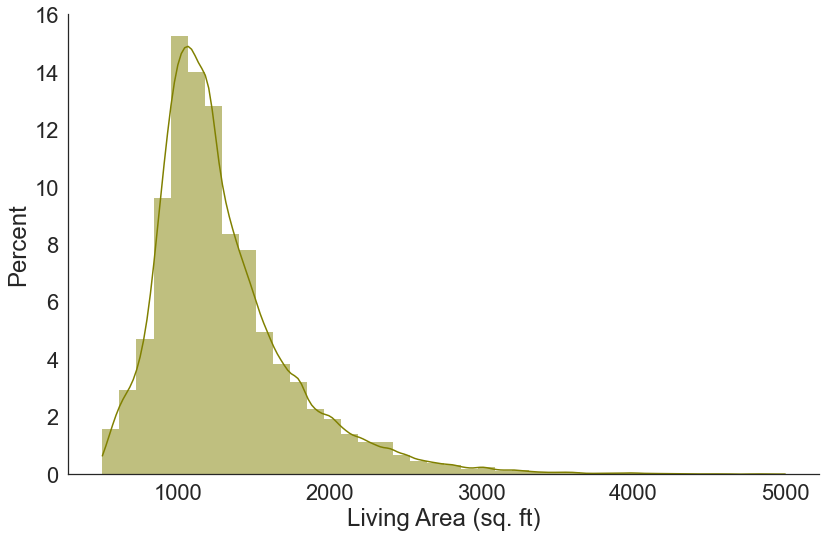

In [14]:
ax = sns.displot(listings_df, x='living_area', kde=True, stat='percent', fill=True, bins=40, height=8, aspect=1.5, linewidth=0, color=plt_color)
ax.set(xlabel="Living Area (sq. ft)")
plt.savefig('./figures/preprocessing/living-area-hist.png', transparent=True)

In [15]:
print("Number of listings: " + str(len(listings_df)))

Number of listings: 122214


### Lot Dimensions

Replace Outliers & NaNs with mean.

In [16]:
min_lot_dimensions = 500
max_lot_dimensions = 50000

In [17]:
# Mean value without outliers
mean_lot_dimensions = listings_df[listings_df['lot_dimensions'] < max_lot_dimensions]['lot_dimensions'].dropna().mean()
print("Mean Lot Dimensions: " + str(mean_lot_dimensions))

Mean Lot Dimensions: 9291.58898148443


In [18]:
# Outliers
listings_df.loc[(listings_df['lot_dimensions'] > max_lot_dimensions), 'lot_dimensions'] = mean_lot_dimensions
# NaNs
listings_df['lot_dimensions'] = listings_df['lot_dimensions'].fillna(mean_lot_dimensions)
# Min Value
listings_df = listings_df[listings_df['lot_dimensions'] >= min_lot_dimensions]

In [19]:
listings_df['lot_dimensions'] = listings_df['lot_dimensions'].astype(int)

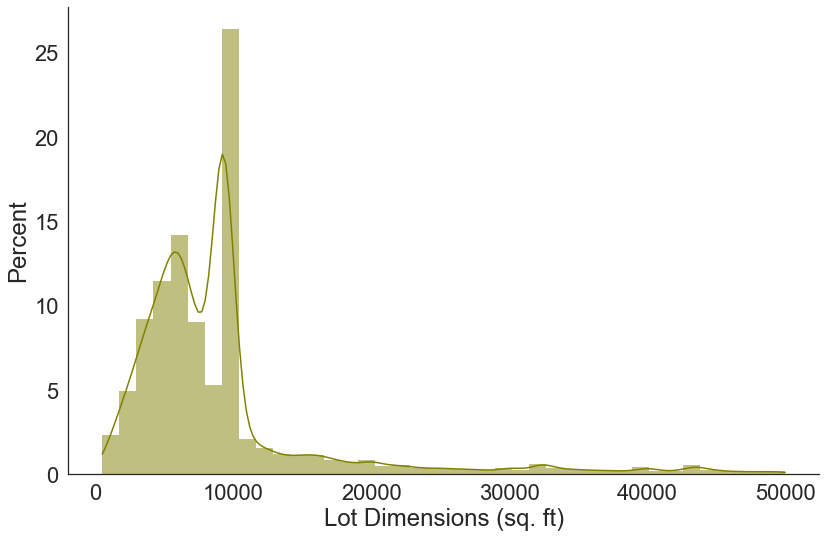

In [20]:
ax = sns.displot(listings_df, x='lot_dimensions', kde=True, stat='percent', fill=True, bins=40, height=8, aspect=1.5, linewidth=0, color=plt_color)
ax.set(xlabel="Lot Dimensions (sq. ft)")
plt.savefig('./figures/preprocessing/lot-dimensions-hist.png', transparent=True)

In [21]:
print("Number of listings: " + str(len(listings_df)))

Number of listings: 121558


### Bedrooms, Bathrooms & Levels
No more than 5 bedrooms, 3 bathrooms and 3 stories.

In [22]:
listings_df['bedrooms'] = listings_df['bedrooms'].fillna(listings_df['bedrooms'].mean())
listings_df['bathrooms'] = listings_df['bathrooms'].fillna(listings_df['bathrooms'].mean())
listings_df['levels'] = listings_df['levels'].fillna(listings_df['levels'].mean())

In [23]:
listings_df.loc[listings_df['bedrooms'] > 5, 'bedrooms'] = 5
listings_df.loc[listings_df['bathrooms'] > 4, 'bathrooms'] = 4
listings_df.loc[listings_df['levels'] > 3, 'levels'] = 3

In [24]:
listings_df['bedrooms'] = listings_df['bedrooms'].astype(int)
listings_df['bathrooms'] = listings_df['bathrooms'].astype(int)
listings_df['levels'] = listings_df['levels'].astype(int)

In [25]:
print("Number of listings: " + str(len(listings_df)))

Number of listings: 121558


### Listing Date
Convert to datetime.

In [26]:
listings_df['listing_date'] = pd.to_datetime(listings_df['listing_date'], format='%Y%m')
print("Number of listings: " + str(len(listings_df)))
listings_df.head()

Number of listings: 121558


,Unnamed: 0,subtype,style,living_area,lot_dimensions,bedrooms,bathrooms,levels,location,listing_date,year_of_construction,municipal_eval,price
0,0,2 Storey,2 storey,1191,4076,3,1,2,Beauport,2020-12-01,2004.0,256000.0,332500.0
1,1,Bungalow,Open area,1261,9500,2,1,1,Deschambault,2021-12-01,1957.0,150500.0,265000.0
2,2,Townhouse,Unknown,1645,1360,3,1,3,Mercier,2021-11-01,2006.0,479400.0,612000.0
4,4,2 Storey,Waterfront,1469,16970,4,2,2,Trois-Rivières,2021-11-01,1925.0,NaN,NaN
5,5,Semi-detached,2 storey,2400,4471,4,2,2,Gatineau,2021-12-01,1989.0,209200.0,360000.0


### Year of Construction
Replace NaNs and outliers with mean value. Convert to int.

In [27]:
min_year_of_construction = 1850
max_year_of_construction = 2021

In [28]:
temp_listings_df = listings_df.copy()
temp_listings_df = temp_listings_df[temp_listings_df['year_of_construction'] >= min_year_of_construction]
temp_listings_df = temp_listings_df[temp_listings_df['year_of_construction'] <= max_year_of_construction]

mean_year_of_construction = temp_listings_df['year_of_construction'].dropna().mean()

print("Mean Year of Construction: " + str(int(mean_year_of_construction)))

Mean Year of Construction: 1990


In [29]:
listings_df['year_of_construction'] = listings_df['year_of_construction'].fillna(mean_year_of_construction)
listings_df.loc[(listings_df['year_of_construction'] <= min_year_of_construction), 'year_of_construction'] = mean_year_of_construction
listings_df.loc[(listings_df['year_of_construction'] >= max_year_of_construction), 'year_of_construction'] = mean_year_of_construction

listings_df['year_of_construction'] = listings_df['year_of_construction'].astype(int)

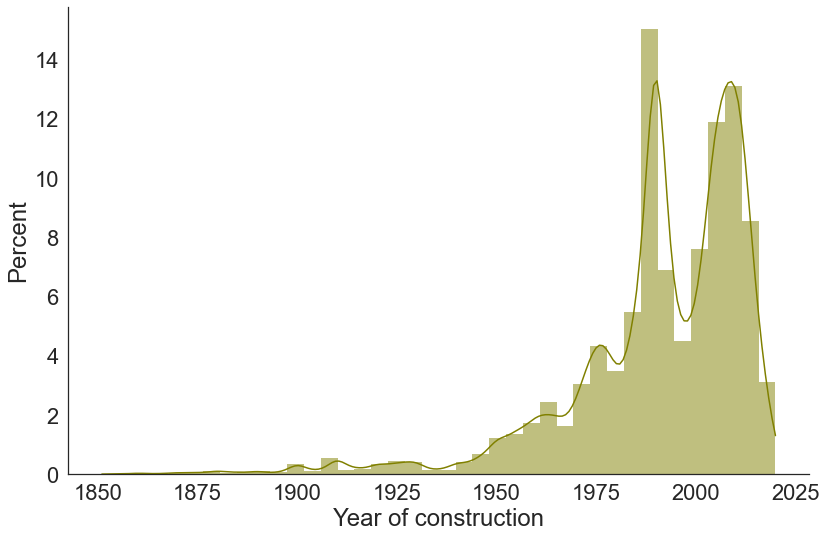

In [30]:
ax = sns.displot(listings_df, x='year_of_construction', kde=True, stat='percent', fill=True, bins=40, height=8, aspect=1.5, linewidth=0, color=plt_color)
ax.set(xlabel="Year of construction")
plt.savefig('./figures/preprocessing/year-of-construction-hist.png', transparent=True)

In [31]:
print("Number of listings: " + str(len(listings_df)))

Number of listings: 121558


### Municipal Evaluation
Dropping this feature.

In [32]:
listings_df = listings_df.drop(['municipal_eval'], axis=1)

print("Number of listings: " + str(len(listings_df)))

Number of listings: 121558


### Price
Remove Outliers and NaNs

In [33]:
min_price = 20000
max_price = 1000000

In [34]:
listings_df = listings_df[listings_df['price'].notna()]
listings_df = listings_df[listings_df['price'] >= min_price]
listings_df = listings_df[listings_df['price'] <= max_price]

In [35]:
listings_df['price'] = listings_df['price'].astype(int)

c:\Users\simka\Documents\GitHub\quebec-real-estate\venv\lib\site-packages\seaborn\axisgrid.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set(**kwargs)


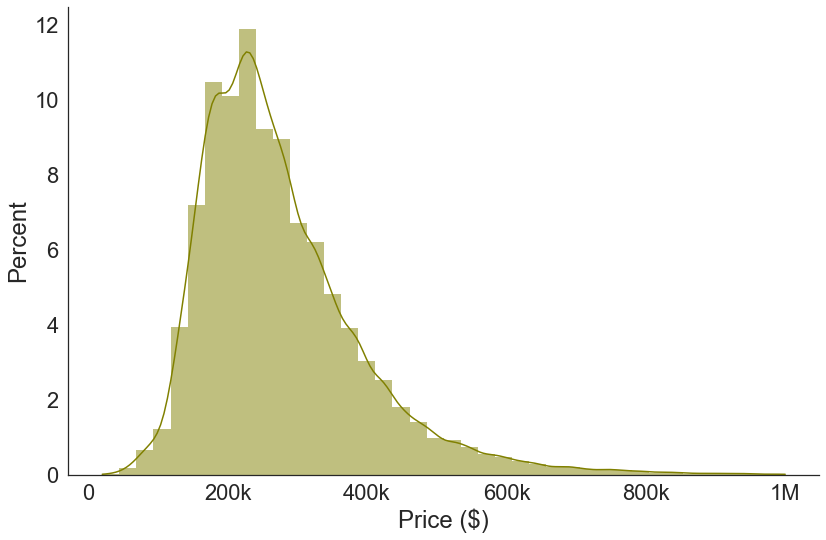

In [36]:
ax = sns.displot(listings_df, x='price', kde=True, stat='percent', fill=True, bins=40, height=8, aspect=1.5, linewidth=0, color=plt_color)
ax.set(xlabel="Price ($)", xticklabels=["0", "0", "200k", "400k", "600k", "800k", "1M"])
plt.savefig('./figures/preprocessing/price-hist.png', transparent=True)

In [37]:
print("Number of listings: " + str(len(listings_df)))

Number of listings: 94783


In [38]:
listings_df[['location']]

,location
0,Beauport
1,Deschambault
2,Mercier
5,Gatineau
6,Alma
...,...
128210,Mercier
128211,Le Sud-Ouest
128212,Le Sud-Ouest
128213,Beauport


### Location

In [39]:
raw_dropna = raw_listings[['location']].dropna()
raw_locations = raw_dropna.groupby('location').mean().astype(int).reset_index()

In [40]:
raw_locations.insert(0, 'Nb of listings', '')
location_value_counts = raw_dropna['location'].value_counts()
raw_locations['Nb of listings'] = raw_locations['location'].map(location_value_counts).astype(int)

In [41]:
raw_locations.to_csv('../data/processed/visualization/raw-locations-dist.csv', index=False)
raw_locations.head(10)

,Nb of listings,location
0,2,Abercorn
1,66,Acton Vale
2,12,Adstock
3,1,Aguanish
4,823,Ahuntsic
5,10,Albanel
6,1,Albertville
7,1,Alleyn-Et-Cawood
8,627,Alma
9,25,Amherst


c:\Users\simka\Documents\GitHub\quebec-real-estate\venv\lib\site-packages\seaborn\axisgrid.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set(**kwargs)


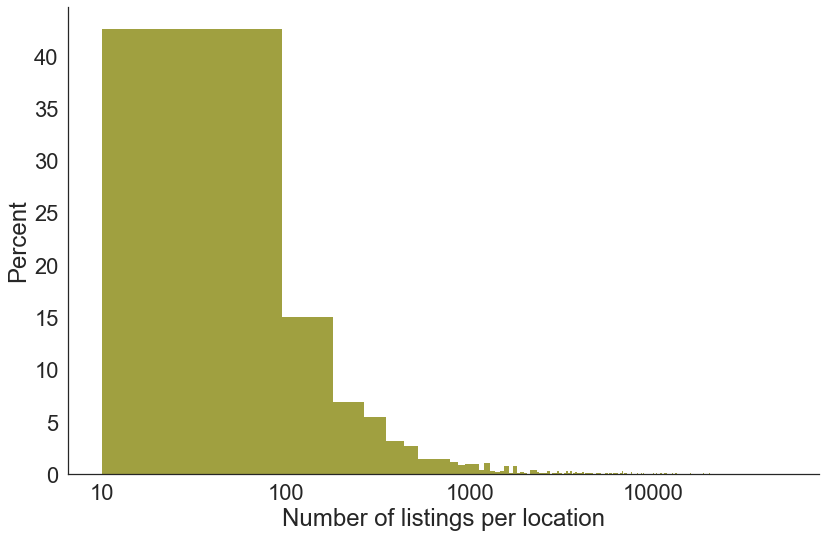

In [42]:
ax = sns.displot(raw_locations, x='Nb of listings', stat="percent", fill=True, height=8, aspect=1.5, linewidth=0, color=plt_color)
ax.set(xscale="log")
ax.set(xlabel="Number of listings per location", xticklabels=["0", "0", "10", "100", "1000", "10000"])
plt.savefig('./figures/preprocessing/raw-locations-dist.png', transparent=True)

Format Raw Location Strings like in the location mapping notebook

In [43]:
listings_df['location'] = listings_df['location'].str.replace('St-', 'Saint-')
listings_df['location'] = listings_df['location'].str.replace('Ste-', 'Sainte-')
listings_df['location'] = listings_df['location'].str.replace('Sts-', 'Saints-')
listings_df['location'] = listings_df['location'].str.replace('ND-', 'Notre-Dame-')
listings_df['location'] = listings_df['location'].str.replace('JC', 'Jacques-Cartier')

In [44]:
unknown_locations_dict = {
    "Saint-Denis-sur-Mer": "Saint-Denis",
    "Saint-Simon-De-Rimouski": "Saint-Simon",
    "Saint-Guillaume-D'Upton": "Saint-Guillaume",
    "Saint-Joseph-De-Ham-Sud": "Ham-Sud",
    "Saint-Adelphe-De-Champlain": "Saint-Adelphe",
    "Saint-Mathieu-De-Laprairie": "Saint-Mathieu",
    "Saint-Isidore-De-Laprairie": "Saint-Isidore",
    "Saint-Stanislas-De-Champlain": "Saint-Denis",
    "Saint-Sebastien-De-Frontenac": "Saint-Sebastien",
    "Sainte-Francoise-De-Lotbiniere": "Saint-Francoise",
    "Saint-Donat-De-Rimouski": "Rimouski",
    "Sheenboro": "Pontiac",
    "Mercier": "Hochelaga", 
    "Mont-Royal": "Ville de Mont-Royal",
    "Rosemont": "Rosemont-La Petite-Patrie",
    "Rivière des Prairies": "Rivière-des-Prairies-Pointe-aux-Trembles",
    "Pointe-Aux-Trembles": "Rivière-des-Prairies-Pointe-aux-Trembles",
    "Côte-des-Neiges": "Côte-des-Neiges–Notre-Dame-de-Grâce"
}

listings_df = listings_df.replace({'location': unknown_locations_dict})

Read Data

In [45]:
# Geographical Boundaries DataFrame
boundaries_df = pd.read_csv('../data/references/handmade/bounding-territories.csv')
boundaries_df = boundaries_df[["Display Name"]]

# Mapper
with open('../data/processed/locations/location-mapper.pkl', 'rb') as f:
    location_mapper = pickle.load(f)

In [46]:
len(set(location_mapper.values()))

112

Replace locations using pre defined mapper.

In [47]:
listings_df = listings_df.replace({'location': location_mapper}).rename(columns={"location": "Location"})
print(len(listings_df["Location"].unique()))

111


In [48]:
listings_df.sample(5)

,Unnamed: 0,subtype,style,living_area,lot_dimensions,bedrooms,bathrooms,levels,Location,listing_date,year_of_construction,price
7437,7437,Townhouse,Townhouse,1331,2968,4,1,2,Dollard-des-Ormeaux,2021-02-01,1975,392000
127277,28175,Condominium,Open area,931,2050,2,1,1,Rosemont-La Petite-Patrie,2007-09-01,1996,169000
25918,25918,Townhouse,2 storey,1627,1400,2,1,2,Le Plateau-Mont-Royal,2019-07-01,1900,868000
91185,91185,2 Storey,New house,1000,2500,4,2,2,Le Haut-Richelieu,2009-08-01,2008,230000
59620,59620,Bungalow,Cathedral roof,2082,34000,2,1,1,La Vallée-du-Richelieu,2015-07-01,1990,299900


In [49]:
df_copy = listings_df[['Location']]
location_df = df_copy.groupby('Location').mean().astype(int).reset_index()

In [50]:
location_df.insert(0, 'Nb of listings', '')
location_value_counts = df_copy['Location'].value_counts()
location_df['Nb of listings'] = location_df['Location'].map(location_value_counts).astype(int)

In [51]:
location_df.to_csv('../data/processed/visualization/locations-dist.csv', index=False)
location_df.head(10)

,Nb of listings,Location
0,667,Abitibi-Témiscamingue
1,604,Ahuntsic-Cartierville
2,198,Anjou
3,256,Antoine-Labelle
4,188,Argenteuil
5,898,Arthabaska & L'Érable
6,769,Auteuil
7,1060,Aylmer
8,1499,Bas-Saint-Laurent
9,40,Beaconsfield


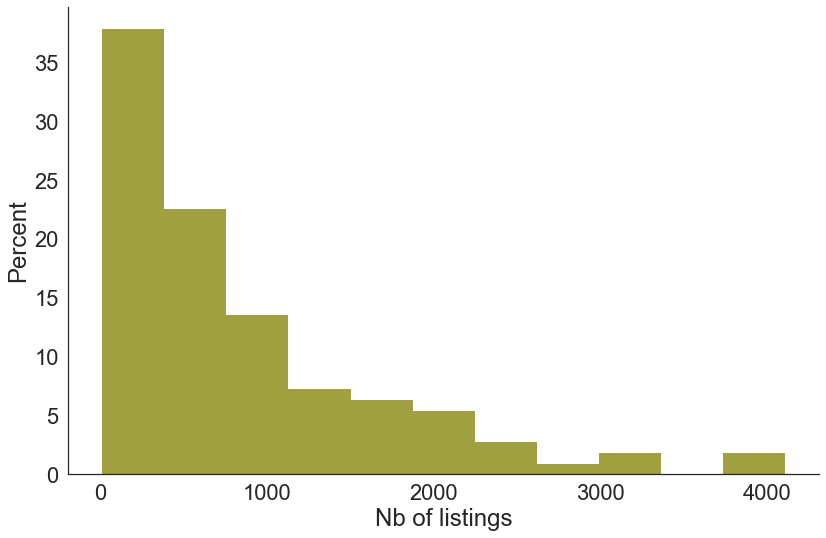

In [52]:
ax = sns.displot(location_df, x='Nb of listings', stat="percent", fill=True, height=8, aspect=1.5, linewidth=0, color=plt_color)
plt.savefig('./figures/preprocessing/locations-dist.png', transparent=True)

### New Columns

Listing Year

In [53]:
listings_df.insert(8, 'listing_year', '')
listings_df['listing_year'] = pd.DatetimeIndex(listings_df['listing_date']).year
listings_df = listings_df[listings_df['listing_year'] <= 2021]

listings_df['listing_year'] = listings_df['listing_year'].astype(int)

Age

In [54]:
listings_df.insert(9, 'age', '')
listings_df['age'] = listings_df['listing_year'] - listings_df['year_of_construction']
listings_df = listings_df[listings_df['age'] >= 0]

listings_df['age'] = listings_df['age'].astype(int)

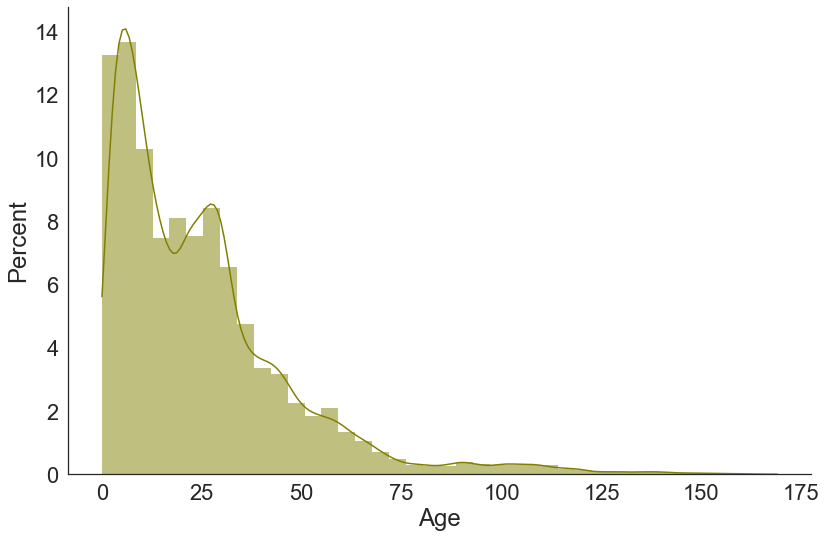

In [55]:
ax = sns.displot(listings_df, x='age', kde=True, stat='percent', fill=True, bins=40, height=8, aspect=1.5, linewidth=0, color=plt_color)
ax.set(xlabel="Age")
plt.savefig('./figures/preprocessing/age-hist.png', transparent=True)

Yard Area

In [56]:
listings_df.insert(10, 'yard_area', '')
listings_df['yard_area'] = listings_df['lot_dimensions'] - listings_df['living_area']
listings_df['yard_area'] = listings_df['yard_area'].mask(listings_df['yard_area'].lt(0), 0)

listings_df['yard_area'] = listings_df['yard_area'].astype(int)

### Rearrange and Rename Columns

In [57]:
listings_df = listings_df[["subtype", "style", "living_area", "lot_dimensions", "bedrooms", "bathrooms",
                           "levels", "listing_date", "listing_year", "year_of_construction", "age", "Location", "price"]]

In [58]:
listings_df = listings_df.rename(columns={"subtype": "Subtype", "style": "Style", "living_area": "Living Area", "lot_dimensions": "Lot Dimensions", "bedrooms": "Bedrooms",
                                 "bathrooms": "Bathrooms", "levels": "Levels", "listing_date": "Listing Date", "listing_year": "Listing Year", "year_of_construction": "Year of Construction", "age": "Age", "price": "Price"})


### Save Data

In [59]:
print("Original Data Length: " + str(len(raw_listings)))
print("Processed Data Length: " + str(len(listings_df)))

Original Data Length: 128215
Processed Data Length: 94639


In [60]:
listings_df.to_csv('../data/processed/processed-listings.csv', index=False)

In [61]:
locations = listings_df['Location'].unique()

In [62]:
len(locations)

111

In [63]:
listings_df.sample(20)

,Subtype,Style,Living Area,Lot Dimensions,Bedrooms,Bathrooms,Levels,Listing Date,Listing Year,Year of Construction,Age,Location,Price
23268,Bungalow,Unknown,960,5040,3,1,1,2019-11-01,2019,1975,44,Longueuil,325000
114427,Condominium,Unknown,875,9291,1,1,1,2016-10-01,2016,2007,9,Villeray-Saint-Michel-Parc-Extension,258000
54858,2 Storey,New construction,2020,10592,3,1,2,2014-09-01,2014,2014,0,La Côte-de-Beaupré & L'Île-d'Orléans,499000
119812,Condominium,New construction,820,9291,1,1,3,2013-08-01,2013,2012,1,Verdun,352361
38431,Semi-detached,Semi-detached,864,4020,2,2,1,2016-07-01,2016,2011,5,Bas-Saint-Laurent,216000
38208,Townhouse,Semi-detached,1271,4098,3,1,2,2017-09-01,2017,1985,32,Dorval,390000
8124,Townhouse,Divided Co-Ownership,600,2906,3,1,1,2021-01-01,2021,1986,35,Les Rivières,211000
39032,Bungalow,Unknown,1050,5000,3,2,1,2018-03-01,2018,1957,61,Lévis,227000
26704,Bungalow,Side split,900,3772,2,2,1,2019-07-01,2019,1997,22,Roussillon,262500
42789,2 Storey,Executive,2200,15600,4,2,2,2015-11-01,2015,2004,11,Le Haut-Richelieu,450000
